# Homework 4: Task 2 - Visualizing fires with false color images

Author: Zach Loo

[GitHub Repository Link](https://github.com/zachyyy700/eds220-hwk4)

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from janitor import clean_names

- Fire Perimeter data source: https://data.ca.gov/dataset/california-fire-perimeters-all

In [7]:
# Load data
fp1 = os.path.join("data", "California_Historic_Fire_Perimeters_-5643920427189821347.geojson")
perimeter_data = gpd.read_file(fp1).clean_names()

fp2 = os.path.join("data", "landsat8-2025-02-23-palisades-eaton.nc")
landsat_data = xr.open_dataset(fp2)

## 2. Fire Perimeter Data Exploration

In [15]:
print(f"{perimeter_data['decades'].value_counts()}\n")
print(f"{perimeter_data.crs}\n")
print(f"{perimeter_data.crs.is_projected}")

decades
1950-1959            7012
2010-2019            3425
2000-2009            2905
1980-1989            2208
2020-January 2025    2036
1990-1999            1992
1970-1979            1879
1960-1969            1276
Name: count, dtype: int64

EPSG:3857

True


**Fire perimeter description**: The fire perimeter data was downloaded from CAL FIRE hosted by California's Open Data Portal. Some preliminary findings about the data included the unique observation counts of the decade variable. It was interesting to see how many observations of wildfires there is for each decade in the data. Next, the CRS was shown to be EPSG:3857 and it is also a projected CRS.

In [9]:
palisades_eaton = perimeter_data[(perimeter_data['fire_name'].isin(['PALISADES', 'EATON'])) & 
                                  (perimeter_data['year_'] == 2025)]

<Axes: >

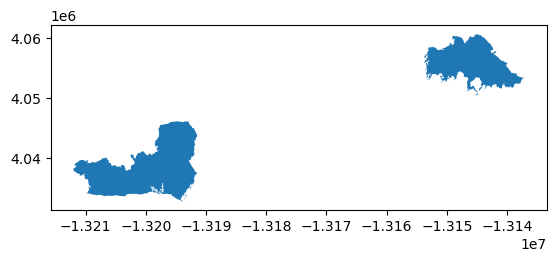

In [10]:
palisades_eaton.plot()

## 3. Landsat Data Exploration

In [12]:
print(f"{landsat_data.dims}\n")
print(f"{landsat_data.coords}\n")
print(f"{landsat_data.data_vars}\n")
print(f"{landsat_data.sizes}")

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...

Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

Frozen({'y': 1418, 'x': 2742})


**Landsat description**:

## 4. Restoring geospatial info

In [7]:
# Print dataset crs
print(landsat_data.rio.crs)

None


In [8]:
# Print spatial ref variable crs
print(landsat_data.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [9]:
# Set dataset CRS
landsat_data.rio.write_crs(landsat_data.spatial_ref.crs_wkt, inplace=True)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...

In [10]:
print(landsat_data.rio.crs)

EPSG:32611


## 5. True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


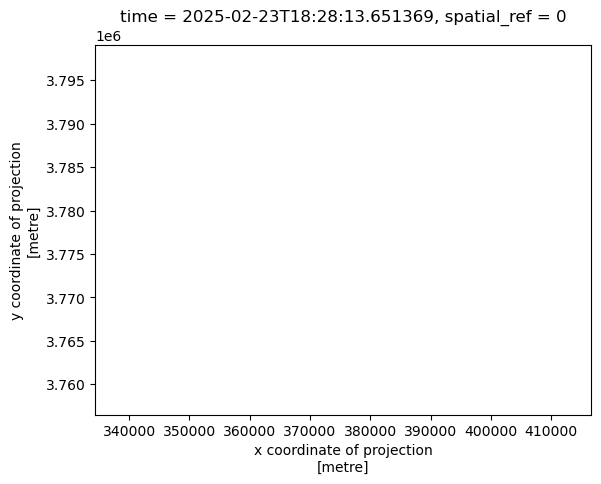

In [11]:
# Select red, green, blue variables
landsat_data[['red', 'green', 'blue']].to_array().plot.imshow()

/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


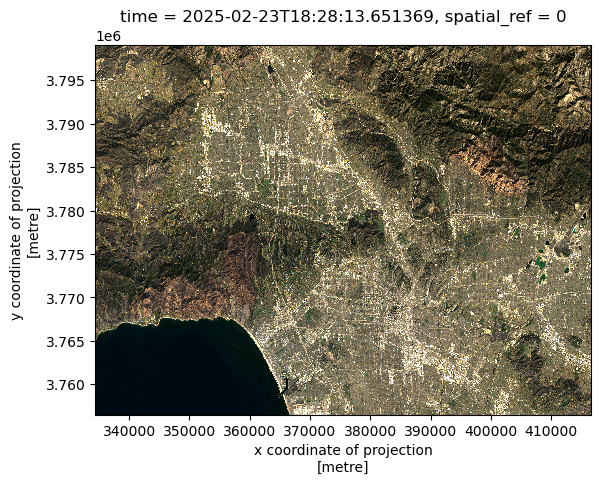

In [12]:
# Use robust argument
landsat_data[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [13]:
# Find which bands have nan values
for i in ['red', 'blue', 'green']:
    band = landsat_data[i].values
    print(f"{i} band has {np.isnan(band).sum()} nan values")

red band has 0 nan values
blue band has 109 nan values
green band has 1 nan values


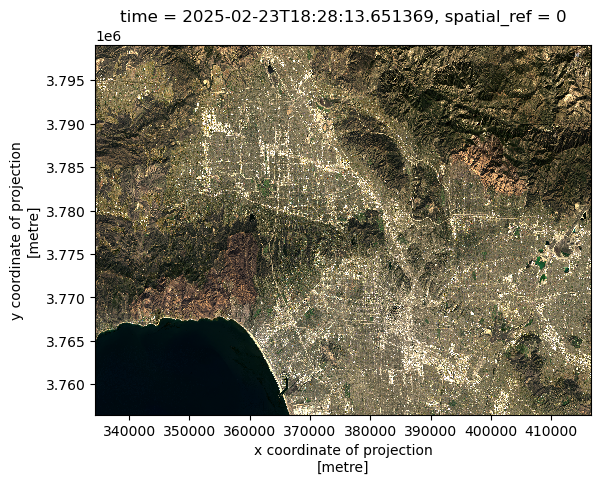

In [14]:
# Fill nans with 0 & plot
landsat_data[['red', 'green', 'blue']].fillna(value=0).to_array().plot.imshow(robust=True)

## 6. False color image

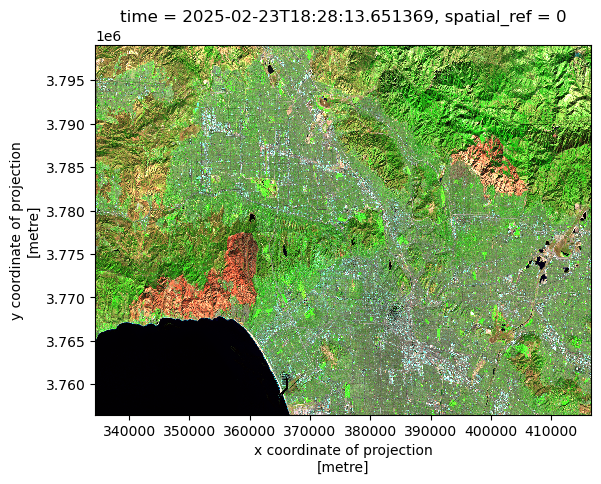

In [15]:
landsat_data[['swir22', 'nir08', 'red']].fillna(value=0).to_array().plot.imshow(robust=True)

## 7. Map

In [16]:
palisades_eaton = palisades_eaton.to_crs("EPSG:32611")

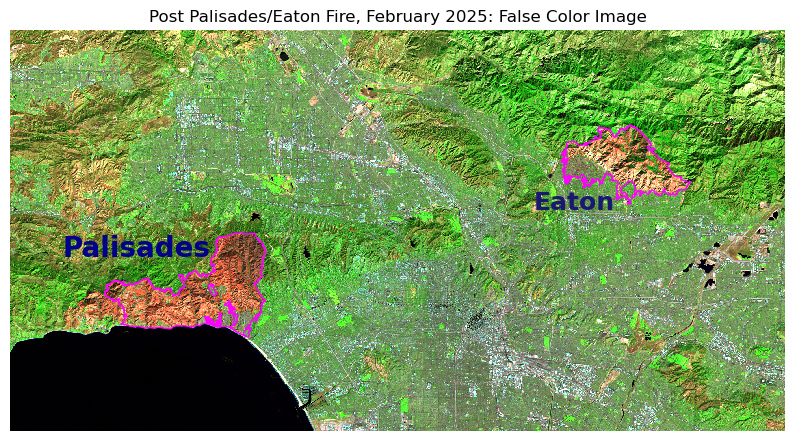

In [25]:
fig, ax = plt.subplots(figsize=(10,8))

ax.axis('off')
landsat_data[['swir22', 'nir08', 'red']].fillna(value=0).to_array().plot.imshow(ax=ax, robust=True)
palisades_eaton.plot(ax=ax, facecolor='None', edgecolor='fuchsia')

ax.text(x=340000, y=3775000, s="Palisades", fontsize=20, color='darkblue', weight='bold')
ax.text(x=390000, y=3780000, s="Eaton", fontsize=18, color='midnightblue', weight='bold')

plt.title("Post Palisades/Eaton Fire, February 2025: False Color Image")
plt.show()